**Student Name**: Phil Miesle

**Student ID**: 23287012

# Task

Open a new Jupyter notebook and name it etivity3_regression.ipynb. In this notebook, train three regression pipelines with Random Forest, Linear Regression and a third regressor of your choice as the final estimator, respectively, for predicting the value of `insurance_cost`.

**Requirements:**

* For each regressor, include data preparation and dimensionality reduction steps in the main pipeline.
* You can choose any regressor as the third one. Some options are SVR and MLPRegressor, but you are not limited to them.
* For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
* Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-2 - Regression and Dimensionality Reduction.ipynb to evaluate and compare the models you have trained and pick the best one.
* Summarise your experience in a markdown cell (max 150 words in a markdown cell).

## Dataset

https://www.kaggle.com/datasets/mirichoi0218/insurance

**Columns**

* age: age of primary beneficiary
* sex: insurance contractor gender, female, male
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: Individual medical costs billed by health insurance

In [1]:
import pandas as pd
df = pd.read_csv('insurance.csv')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   gender          1338 non-null   object 
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   object 
 5   region          1338 non-null   object 
 6   insurance_cost  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


age  gender     bmi  children smoker     region  insurance_cost
0      18    male  33.770         1     no  southeast      1725.55230
1      18    male  34.100         0     no  southeast      1137.01100
2      18  female  26.315         0     no  northeast      2198.18985
3      18  female  38.665         2     no  northeast      3393.35635
4      18  female  35.625         0     no  northeast      2211.13075
...   ...     ...     ...       ...    ...        ...             ...
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

[1338 rows x 7 columns]

# EDA

We'll again split our dataset:

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1618, shuffle=True)

In [6]:
X_train = train_df.drop('insurance_cost', axis=1)
y_train = train_df['insurance_cost']

X_test = test_df.drop('insurance_cost', axis=1)
y_test = test_df['insurance_cost']

The data is identical to what we had previously, though we've not looked at the output in detail, so let's have a look at it to see if we need to consider if we will need to address any skew as in the example notebook.

<Axes: xlabel='insurance_cost', ylabel='Count'>

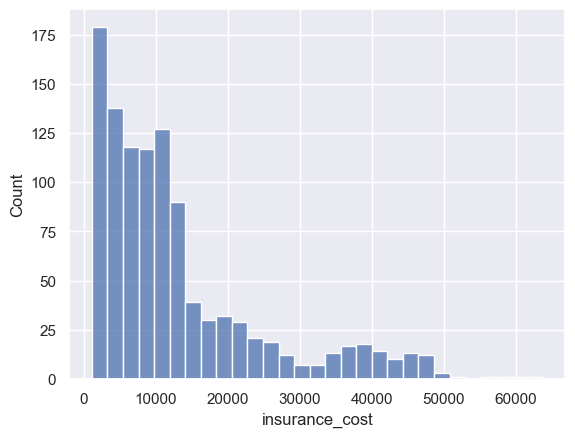

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

sns.histplot(y_train)


As in the example notebook, the data has a right skew. Let's have a look at a boxplot too:

<Axes: ylabel='insurance_cost'>

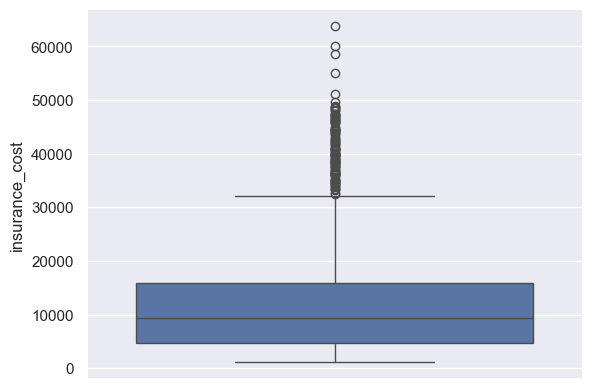

In [11]:
sns.boxplot(y_train)

And quite a few outliers, so we will need to consider that too!

In [17]:
y_train.describe()

count     1070.000000
mean     12924.282278
std      11717.455405
min       1121.873900
25%       4747.525500
50%       9412.962500
75%      15820.020675
max      63770.428010
Name: insurance_cost, dtype: float64

So that confirms no zero values, and then I'd note the mean looks to be pulled up about 20% from the median (visually on the box plot), no doubt down to the skew!

## Data Preparation

We have the same data in this notebook as Task 1, so let's just reuse that data prep. (fwiw I'd prefer to consolidate this into a separate `.py` file and import into both notebooks, but will copy-paste for now...)

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

class QuantileBinner(BaseEstimator, TransformerMixin):
    def __init__(self, n_quantiles=10):
        self.n_quantiles = n_quantiles
        self.bins = None
        
    def fit(self, X, y=None):
        self.bins = pd.qcut(X.squeeze(), q=self.n_quantiles, retbins=True, duplicates='drop')[1]
        return self

    def transform(self, X):
        return pd.cut(X.squeeze(), bins=self.bins, labels=False, include_lowest=True).to_frame()

def create_age_pipeline():
    age_pipeline = Pipeline([
        ('quantile_binner', QuantileBinner(n_quantiles=10)),
        ('encoder', OneHotEncoder(categories='auto', drop='first'))
    ])
    return age_pipeline

class CapFeature(BaseEstimator, TransformerMixin):
    def __init__(self, max_val=3):
        self.max_val = max_val
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)
        return X.clip(upper=self.max_val).to_numpy()


def create_preprocessing_pipeline():
    age_pipeline=create_age_pipeline()
    
    pipeline = ColumnTransformer(
        transformers=[
            ('age', age_pipeline, ['age']),
            ('bmi', RobustScaler(), ['bmi']),
            ('children', CapFeature(3), ['children']),
            ('one_hot', OneHotEncoder(drop='first'), ['gender','smoker','region']),
        ],
        remainder='passthrough'
    )
    return pipeline


# Regressors

In [13]:
from sklearn.preprocessing import FunctionTransformer

# PCA doesn't like sparse arrays, so given the small dataset I will throw a converter into the pipeline
def to_dense(X):
    return X.toarray()

# Set the dimensionality reduction options on the search grid
num_features = 16
reduce_dim_options = [int(num_features * frac) for frac in [1/4, 1/2, 3/4]]

## Random Forest

This is basically out of thet tutorial notebook

In [22]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

rf_pipe = Pipeline(steps=[
    ('preprocess', create_preprocessing_pipeline()), 
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)), 
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=10),
        func=np.log, 
        inverse_func=np.exp)
    )
    ]
)

MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

rf_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': reduce_dim_options,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': reduce_dim_options,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }  
]

RF_search = GridSearchCV(rf_pipe, rf_param_grid, n_jobs=-1, cv=5, refit=True)
RF_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % RF_search.best_score_)
print("Best parameters: ", RF_search.best_params_)

# store the best params and best model for later use
RF_best_params = RF_search.best_params_
RF_best_model = RF_search.best_estimator_

Best CV score = 0.825:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 8, 'ttr__regressor__max_depth': 6}


## Linear Regressor

In [16]:
lr_pipe = Pipeline(steps=[
    ('preprocess', create_preprocessing_pipeline()), 
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)), 
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log, 
        inverse_func=np.exp)
    )
    ]
)

lr_param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': reduce_dim_options
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': reduce_dim_options
    }  
]

LR_search = GridSearchCV(lr_pipe, lr_param_grid, n_jobs=-1, cv=5, refit=True)
LR_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % LR_search.best_score_)
print("Best parameters: ", LR_search.best_params_)

# Store the best params and best model for later use
LR_best_params = LR_search.best_params_
LR_best_model = LR_search.best_estimator_

Best CV score = 0.588:
Best parameters:  {'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 12}


## Gradient Boosting Regressor

It seemed like an interesting name, https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html indicates:

> This example demonstrates Gradient Boosting to produce a predictive model from an ensemble of weak predictive models. Gradient boosting can be used for regression and classification problems.

And there are a number of examples on the interwebs involving this regressor and financial data, for example https://corporatefinanceinstitute.com/resources/data-science/gradient-boosting/. 

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gb_pipe = Pipeline(steps=[
    ('preprocess', create_preprocessing_pipeline()), 
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)), 
    ('reduce_dim', 'passthrough'),
    ('ttr', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(),
        func=np.log, 
        inverse_func=np.exp)
    )
    ]
)

gb_param_grid = {
    'reduce_dim': [PCA(iterated_power=7)],
    'reduce_dim__n_components': reduce_dim_options,
    'ttr__regressor__n_estimators': [100, 200, 300],
    'ttr__regressor__learning_rate': [0.01, 0.1, 0.2],
}

GB_search = GridSearchCV(gb_pipe, gb_param_grid, n_jobs=-1, cv=5, refit=True)
GB_search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % GB_search.best_score_)
print("Best parameters: ", GB_search.best_params_)

# Store the best params and best model for later use
GB_best_params = GB_search.best_params_
GB_best_model = GB_search.best_estimator_

Best CV score = 0.795:
Best parameters:  {'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 12, 'ttr__regressor__learning_rate': 0.1, 'ttr__regressor__n_estimators': 100}


## Saving Data

In [23]:
import pickle

grid_searches = [RF_search, LR_search, GB_search]
with open('grid_searches_regression.pkl', 'wb') as file:
    pickle.dump(grid_searches, file)